In [0]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

Using TensorFlow backend.


In [0]:
!wget https://www.dropbox.com/s/2vag8w6yov9c1qz/english%20to%20french.txt

--2019-02-19 02:32:34--  https://www.dropbox.com/s/2vag8w6yov9c1qz/english%20to%20french.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2vag8w6yov9c1qz/english%20to%20french.txt [following]
--2019-02-19 02:32:35--  https://www.dropbox.com/s/raw/2vag8w6yov9c1qz/english%20to%20french.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f6062c040196e446508c3f2a9.dl.dropboxusercontent.com/cd/0/inline/Abn7zKLw18Z5qAaMqhXnxuLj44SvrxzX_IMijgzRh3cLQ67JieH1kRxrOHGxAcUzvTuG7_Be1aE08Gfqdekl3NvpL3oQCh0wPOYUMNW0t65m2hZSkXdys4Myc5PBczEm3mg/file# [following]
--2019-02-19 02:32:35--  https://uc7f6062c040196e446508c3f2a9.dl.dropboxusercontent.com/cd/0/inline/Abn7zKLw18Z5qAaMqhXnxuLj44SvrxzX_IMijgzRh3cLQ67JieH1kRxrOHGxAcUzvTuG7_Be

In [0]:
!ls

'english to french.txt'   sample_data


In [0]:
lines= pd.read_table('english to french.txt', names=['eng', 'fr'])

In [0]:
lines = lines[0:50000]

In [0]:
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.fr=lines.fr.apply(lambda x: x.lower())

In [0]:
# lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
# lines.fr=lines.fr.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

In [0]:
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
lines.head()

,eng,fr
0,go,va
1,run,cours
2,run,courez
3,wow,ça alors
4,fire,au feu


In [0]:
# remove_digits = str.maketrans('', '', digits)
# lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
# lines.fr=lines.fr.apply(lambda x: x.translate(remove_digits))

In [0]:
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [0]:
lines.head()

,eng,fr
0,go,start va end
1,run,start cours end
2,run,start courez end
3,wow,start ça alors end
4,fire,start au feu end


In [0]:
lines.shape

(50000, 2)

In [0]:
# fit a tokenizer
from keras.preprocessing.text import Tokenizer
import json
from collections import OrderedDict
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [0]:
eng_tokenizer = create_tokenizer(lines.eng)
output_dict = json.loads(json.dumps(eng_tokenizer.word_counts))
df =pd.DataFrame([output_dict.keys(), output_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_eng_words = df[df['cum_perc']<0.8]['word'].values

In [0]:
fr_tokenizer = create_tokenizer(lines.fr)
output_dict = json.loads(json.dumps(fr_tokenizer.word_counts))
df =pd.DataFrame([output_dict.keys(), output_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)
df['cum_count']=df['count'].cumsum()
df['cum_perc'] = df['cum_count']/df['cum_count'].max()
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [0]:
print(len(final_eng_words),len(final_fr_words))

384 357


In [0]:
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
filter_eng_words('he is extremely good')

'he is unk good '

In [0]:
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '
  return x3

In [0]:
lines['fr']=lines['fr'].apply(filter_fr_words)

In [0]:
lines['eng']=lines['eng'].apply(filter_eng_words)

In [0]:
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [0]:
lenght_list=[]
for l in lines.fr:
    lenght_list.append(len(l.split(' ')))
fr_max_length = np.max(lenght_list)

In [0]:
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
eng_max_length = np.max(lenght_list)

In [0]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
# del all_eng_words, all_french_words

In [0]:
set(all_french_words) - set(final_fr_words) 

{'unk'}

In [0]:
len(all_eng_words)

385

In [0]:
len(target_words)

358

In [0]:
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [0]:
num_decoder_tokens

358

# Traditional many to many architecture

In [0]:
encoder_input_data = np.zeros(
    (len(lines.eng), fr_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines.fr), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [0]:
decoder_target_data.shape

(50000, 17, 359)

In [0]:
for i, (input_text, target_text) in enumerate(zip(lines.eng, lines.fr)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:          
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
          decoder_target_data[i, t - 1, target_token_index[word]] = 1.
          if t== len(target_text.split())-1:
            decoder_target_data[i, t:, 89] = 1

In [0]:
print(decoder_input_data.shape,encoder_input_data.shape,decoder_target_data.shape)

(50000, 17) (50000, 17) (50000, 17, 359)


In [0]:
for i in range(decoder_input_data.shape[0]):
  for j in range(decoder_input_data.shape[1]):
    if(decoder_input_data[i][j]==0):
      decoder_input_data[i][j] = 89

In [0]:
decoder_input_data[0]

array([284., 321.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,
        89.,  89.,  89.,  89.,  89.,  89.], dtype=float32)

In [0]:
np.argmax(decoder_target_data[0],axis=1)

array([321,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
        89,  89,  89,  89])

In [0]:
decoder_input_data[1]

array([284., 320.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,  89.,
        89.,  89.,  89.,  89.,  89.,  89.], dtype=float32)

In [0]:
np.argmax(decoder_target_data[1],axis=1)

array([320,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
        89,  89,  89,  89])

In [0]:
import os
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
from keras.layers import Embedding
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Bidirectional

In [0]:
# define NMT model
model = Sequential()
model.add(Embedding(len(input_words)+1, 128, input_length=fr_max_length, mask_zero=True))
model.add((Bidirectional(LSTM(256, return_sequences = True))))
#model.add(RepeatVector(fr_max_length))
model.add((LSTM(256, return_sequences=True)))
model.add((Dense(len(target_token_index)+1, activation='softmax')))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 17, 128)           49408     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 17, 512)           788480    
_________________________________________________________________
lstm_14 (LSTM)               (None, 17, 256)           787456    
_________________________________________________________________
dense_8 (Dense)              (None, 17, 359)           92263     
Total params: 1,717,607
Trainable params: 1,717,607
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

In [0]:
history = model.fit(encoder_input_data, decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)

Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 72s 2ms/step - loss: 3.5103 - acc: 0.3292 - val_loss: 3.1189 - val_acc: 0.3897
Epoch 2/5
47500/47500 [==============================] - 66s 1ms/step - loss: 2.5144 - acc: 0.4605 - val_loss: 2.6546 - val_acc: 0.4337
Epoch 3/5
47500/47500 [==============================] - 65s 1ms/step - loss: 2.1207 - acc: 0.5068 - val_loss: 2.4025 - val_acc: 0.4573
Epoch 4/5
47500/47500 [==============================] - 65s 1ms/step - loss: 1.8839 - acc: 0.5398 - val_loss: 2.2232 - val_acc: 0.4792
Epoch 5/5
47500/47500 [==============================] - 65s 1ms/step - loss: 1.7154 - acc: 0.5653 - val_loss: 2.1427 - val_acc: 0.4936


In [0]:
history_dict

{'acc': [0.3291754581118885,
  0.46052813366337825,
  0.5067806038178896,
  0.5398264069306223,
  0.5652564989391126],
 'loss': [3.510349987973665,
  2.514400591719778,
  2.1207436878605894,
  1.8838900062159487,
  1.7154197012750727],
 'val_acc': [0.3896924932956696,
  0.4337011303901672,
  0.4572536667346954,
  0.4792308346748352,
  0.4935678668498993],
 'val_loss': [3.1188916458129885,
  2.654617192840576,
  2.402529670524597,
  2.2231661935806275,
  2.1427400732040405]}

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


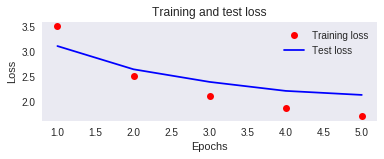

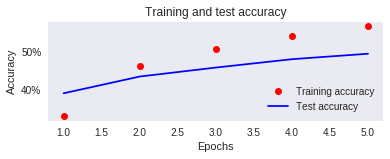

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
encoder_input_data[0]

array([120.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

In [0]:
count = 0
correct_count = 0
pred = model.predict(encoder_input_data[47500:])
for i in range(2500):
  t = np.argmax(pred[i], axis=1)
  act = np.argmax(decoder_target_data[47500],axis=1)
  correct_count += np.sum((act==t) & (act!=89))
  count += np.sum(act!=89)
correct_count/count

0.19513333333333333

In [0]:
decoder_input_data[47500+i]!=89

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False])

In [0]:
t

array([ 86, 203, 282,  63, 320, 320, 320, 320, 320, 320, 320, 320, 320,
       320, 320, 320, 320])

In [0]:
decoder_input_data[47500+i]

array([284.,  86., 320.,  63., 149., 307.,  89.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

In [0]:
encoder_input_data = np.zeros(
    (len(lines.eng), eng_max_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(lines.fr), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(lines.eng, lines.fr)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[word]
        if t>0:          
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
          decoder_target_data[i, t - 1, target_token_index[word]] = 1.
          if t== len(target_text.split())-1:
            decoder_target_data[i, t:, 89] = 1
			
for i in range(decoder_input_data.shape[0]):
  for j in range(decoder_input_data.shape[1]):
    if(decoder_input_data[i][j]==0):
      decoder_input_data[i][j] = 89			

In [0]:
# define NMT model
model2 = Sequential()
model2.add(Embedding(len(input_words)+1, 128, input_length=eng_max_length, mask_zero=True))
model2.add((Bidirectional(LSTM(256))))
model2.add(RepeatVector(fr_max_length))
model2.add((LSTM(256, return_sequences=True)))
model2.add(TimeDistributed(Dense(len(target_token_index)+1, activation='softmax')))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 8, 128)            49408     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 512)               788480    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 17, 512)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 17, 256)           787456    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17, 359)           92263     
Total params: 1,717,607
Trainable params: 1,717,607
Non-trainable params: 0
_________________________________________________________________


In [0]:
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
history1 = model2.fit(encoder_input_data, decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)			

Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 45s 956us/step - loss: 1.2286 - acc: 0.7883 - val_loss: 1.2638 - val_acc: 0.7593
Epoch 2/5
47500/47500 [==============================] - 39s 821us/step - loss: 0.9180 - acc: 0.8148 - val_loss: 1.1343 - val_acc: 0.7730
Epoch 3/5
47500/47500 [==============================] - 39s 821us/step - loss: 0.7687 - acc: 0.8362 - val_loss: 1.0001 - val_acc: 0.7863
Epoch 4/5
47500/47500 [==============================] - 39s 821us/step - loss: 0.6691 - acc: 0.8487 - val_loss: 0.9130 - val_acc: 0.7963
Epoch 5/5
47500/47500 [==============================] - 39s 819us/step - loss: 0.6027 - acc: 0.8570 - val_loss: 0.8836 - val_acc: 0.7985


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


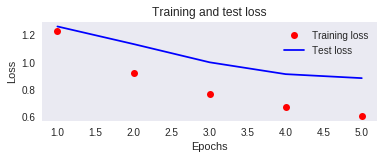

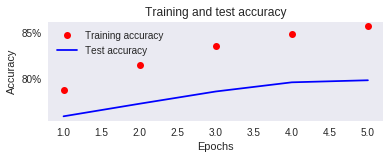

In [0]:
history_dict = history1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history1.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history1.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
encoder_input_data.shape

(50000, 8)

In [0]:
count = 0
correct_count = 0
pred = model2.predict(encoder_input_data[47500:])
for i in range(2500):
  t = np.argmax(pred[i], axis=1)
  act = np.argmax(decoder_target_data[47500],axis=1)
  correct_count += np.sum((act==t) & (act!=89))
  count += np.sum(act!=89)
correct_count/count

0.18986666666666666

In [0]:
t = model2.predict(encoder_input_data[k+i].reshape(1,encoder_input_data.shape[1])).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])


ils
unk
unk
dans
la
unk
end


In [0]:
t2 = decoder_input_data[k+i]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

start
vous
ne
me
unk
pas
du
tout
end


In [0]:
embedding_size = 128
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model

In [0]:
encoder_inputs = Input(shape=(None,))
en_x=  Embedding(num_encoder_tokens+1, embedding_size)(encoder_inputs)
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(en_x)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [0]:
decoder_inputs = Input(shape=(None,))

dex=  Embedding(num_decoder_tokens+1, embedding_size)

final_dex= dex(decoder_inputs)


decoder_lstm = LSTM(256, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(final_dex,
                                     initial_state=encoder_states)

decoder_outputs = Dense(2000,activation='tanh')(decoder_outputs)

decoder_dense = Dense(num_decoder_tokens+1, activation='softmax')

decoder_outputs = decoder_dense(decoder_outputs)

model3 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 128)    49408       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, None, 128)    45952       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_17 (L

In [0]:
history3 = model3.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=5,
          validation_split=0.05)

Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 33s 687us/step - loss: 1.0624 - acc: 0.8078 - val_loss: 1.0780 - val_acc: 0.7849
Epoch 2/5
47500/47500 [==============================] - 26s 539us/step - loss: 0.6807 - acc: 0.8551 - val_loss: 0.8477 - val_acc: 0.8126
Epoch 3/5
47500/47500 [==============================] - 26s 547us/step - loss: 0.5336 - acc: 0.8744 - val_loss: 0.7143 - val_acc: 0.8292
Epoch 4/5
47500/47500 [==============================] - 26s 545us/step - loss: 0.4491 - acc: 0.8878 - val_loss: 0.6329 - val_acc: 0.8430
Epoch 5/5
47500/47500 [==============================] - 26s 547us/step - loss: 0.3945 - acc: 0.8973 - val_loss: 0.5940 - val_acc: 0.8484


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


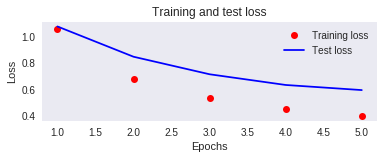

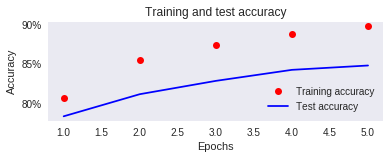

In [0]:
history_dict = history3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history3.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history3.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
decoder_target_data.shape

(50000, 17, 359)

In [0]:
act = np.argmax(decoder_target_data, axis=2)
act.shape

(50000, 17)

In [0]:
act[0]

array([321,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
        89,  89,  89,  89])

In [0]:
count = 0
correct_count = 0
pred = model3.predict([encoder_input_data[47500:],decoder_input_data[47500:]])
for i in range(2500):
  t = np.argmax(pred[i], axis=1)
  correct_count += np.sum((act[47500+i]==t) & (act[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count

0.4468165264347608

In [0]:
target_token_index['end']

89

In [0]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

In [0]:
final_pred = []
for i in range(2500):
  if(i%10==0):
    print(i)
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model3.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==89:
      break
  final_pred.append(list(decoder_input_data_pred[47500+i]))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [0]:
final_pred2 = np.array(final_pred)
final_pred2.shape

(2500, 17)

In [0]:
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count

0.4592490267487128

In [0]:
# encoder_input_data = np.zeros(
#     (len(lines.eng), eng_max_length),
#     dtype='float32')
# decoder_input_data = np.zeros(
#     (len(lines.fr), fr_max_length),
#     dtype='float32')
# decoder_target_data = np.zeros(
#     (len(lines.fr), fr_max_length, num_decoder_tokens+1),
#     dtype='float32')
	
# for i, (input_text, target_text) in enumerate(zip(lines.eng, lines.fr)):
#     for t, word in enumerate(input_text.split()):
#         encoder_input_data[i, t] = input_token_index[word]
#     for t, word in enumerate(target_text.split()):
#         # decoder_target_data is ahead of decoder_input_data by one timestep
#         decoder_input_data[i, t] = target_token_index[word]
#         if t>0:          
#             # decoder_target_data will be ahead by one timestep
#             # and will not include the start character.
#           decoder_target_data[i, t - 1, target_token_index[word]] = 1.
#           if t== len(target_text.split())-1:
#             decoder_target_data[i, t:, 0] = 1

In [0]:
embedding_size = 128

In [0]:
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, embedding_size)(encoder_inputs)
en_x = Dropout(0.1)(en_x)
encoder = LSTM(256, return_sequences=True, unroll=True)(en_x)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
encoder Tensor("lstm_19/transpose_1:0", shape=(?, 8, 256), dtype=float32)
encoder_last Tensor("strided_slice:0", shape=(?, 256), dtype=float32)


In [0]:
decoder_inputs = Input(shape=(fr_max_length,))

dex=  Embedding(num_decoder_tokens+1, embedding_size)
#dex = Dropout(0.1)(dex)

decoder= dex(decoder_inputs)
decoder = Dropout(0.1)(decoder)

decoder = LSTM(256, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])
print('decoder', decoder)

decoder Tensor("lstm_20/transpose_1:0", shape=(?, 17, 256), dtype=float32)


In [0]:
t = Dense(5000, activation='tanh')(decoder)
#t = Dense(5, activation='tanh')(t)
t

<tf.Tensor 'dense_12/Tanh:0' shape=(?, 17, 5000) dtype=float32>

In [0]:
t2 = Dense(5000, activation='tanh')(encoder)
#t2 = Dense(5, activation='tanh')(t2)
t2

<tf.Tensor 'dense_13/Tanh:0' shape=(?, 8, 5000) dtype=float32>

In [0]:
from keras.layers import Activation, dot, concatenate

attention = dot([t, t2], axes=[2, 2])
attention

<tf.Tensor 'dot_1/MatMul:0' shape=(?, 17, 8) dtype=float32>

In [0]:
# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
# attention = dot([decoder, encoder], axes=[2, 2])
# print(attention)
attention = Dense(eng_max_length, activation='tanh')(attention)
attention = Activation('softmax')(attention)
print('attention', attention)

attention Tensor("activation_1/truediv:0", shape=(?, 17, 8), dtype=float32)


In [0]:
context = dot([attention, encoder], axes = [2,1])
context


<tf.Tensor 'dot_2/MatMul:0' shape=(?, 17, 256) dtype=float32>

In [0]:
decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 17, 512), dtype=float32)


In [0]:
output_dict_size = num_decoder_tokens+1
#output = (Dense(100, activation="relu"))(decoder_combined_context)
#output = (Dense(output_dict_size, activation="softmax"))(output)
#decoder_combined_context = Dense(200, activation='tanh')(decoder_combined_context)
#decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
output = (Dense(output_dict_size, activation="softmax"))(decoder_combined_context)
print('output', output)

output Tensor("dense_16/truediv:0", shape=(?, 17, 359), dtype=float32)


In [0]:
model4 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model4.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [0]:
model4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 17, 128)      45952       input_6[0][0]                    
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 8, 128)       49408       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [0]:
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
from keras.utils import plot_model

In [0]:
plot_model(model4, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image

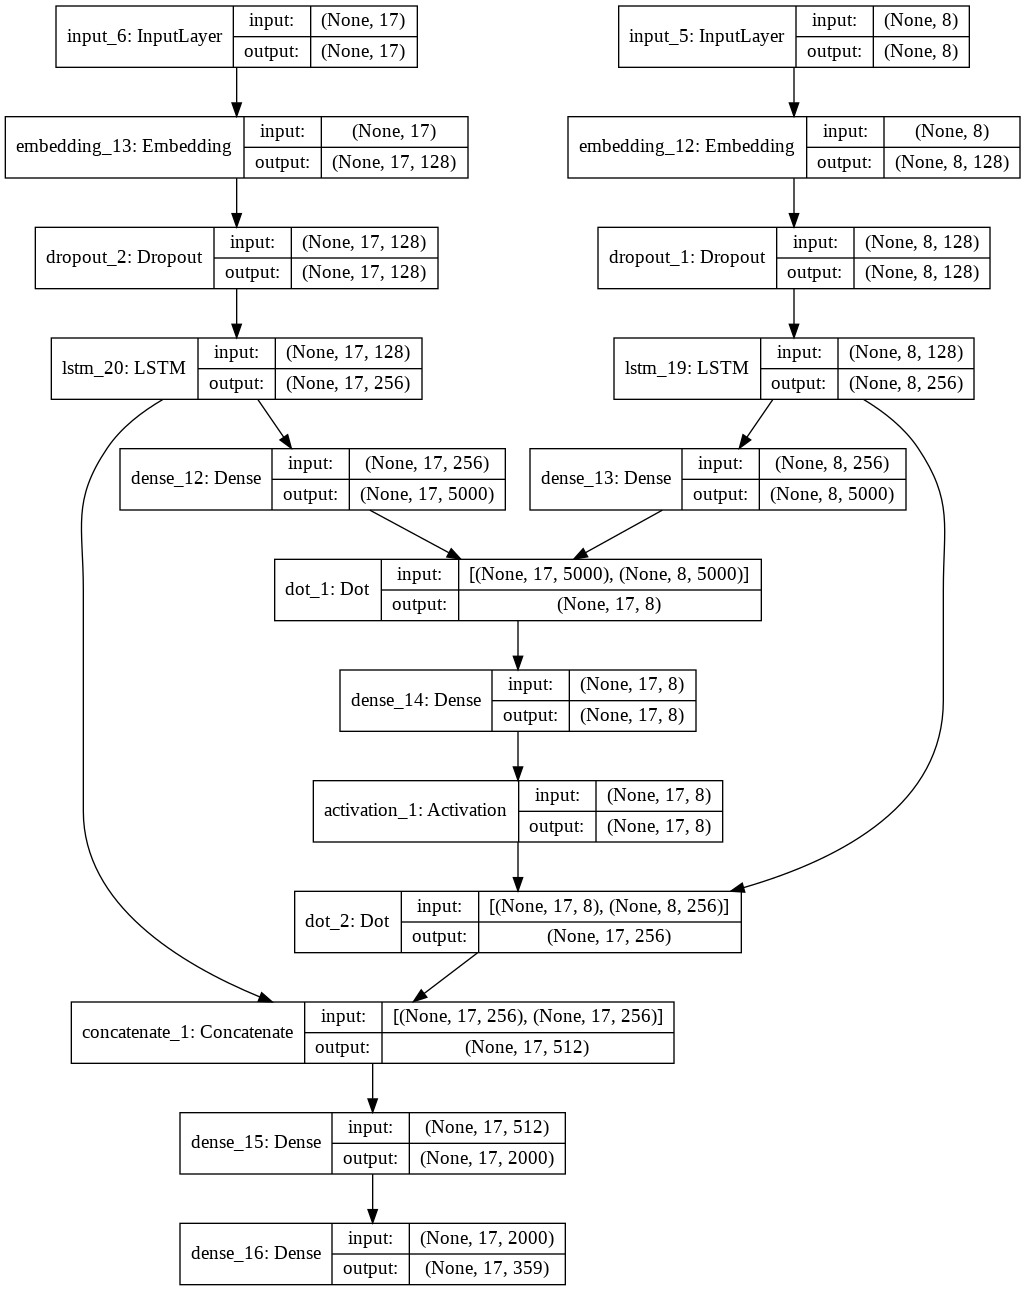

In [0]:
Image(retina=True, filename='model.png')

In [0]:
history4 = model4.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=5,
          validation_split=0.05)

Train on 47500 samples, validate on 2500 samples
Epoch 1/5
47500/47500 [==============================] - 99s 2ms/step - loss: 0.7249 - acc: 0.8505 - val_loss: 0.6900 - val_acc: 0.8353
Epoch 2/5
47500/47500 [==============================] - 89s 2ms/step - loss: 0.4319 - acc: 0.8908 - val_loss: 0.5942 - val_acc: 0.8504
Epoch 3/5
47500/47500 [==============================] - 89s 2ms/step - loss: 0.3770 - acc: 0.9003 - val_loss: 0.5469 - val_acc: 0.8600
Epoch 4/5
47500/47500 [==============================] - 89s 2ms/step - loss: 0.3447 - acc: 0.9068 - val_loss: 0.5272 - val_acc: 0.8640
Epoch 5/5
47500/47500 [==============================] - 89s 2ms/step - loss: 0.3211 - acc: 0.9112 - val_loss: 0.5016 - val_acc: 0.8687


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


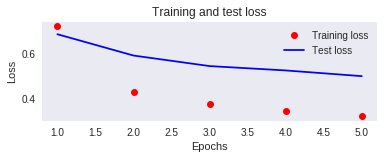

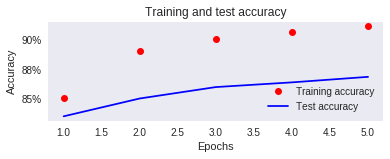

In [0]:
history_dict = history4.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history4.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history4.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

final_pred_att = []
for i in range(2500):
  if(i%10==0):
    print(i)
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model4.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==89:
      break
  final_pred_att.append(list(decoder_input_data_pred[47500+i]))	

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [0]:
final_pred2_att = np.array(final_pred_att)
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2_att[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count  

0.5206580434509607

In [0]:
k = -2400

In [0]:
t = model4.predict([encoder_input_data[k].reshape(1,encoder_input_data.shape[1]),decoder_input_data[k].reshape(1,decoder_input_data.shape[1])]).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)

In [0]:
for i in range(len(encoder_input_data[k])):
  if int(encoder_input_data[k][i])!=0:
    print(list(input_token_index.keys())[int(encoder_input_data[k][i]-1)])

i
feel
like
unk


In [0]:
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

je
unk
de
unk
la
unk
end


In [0]:
t2 = decoder_input_data[k]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

start
jai
unk
de
faire
la
unk
end


In [0]:
decoder_input_data[0]

array([1.00e+00, 4.28e+03, 2.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
      dtype=float32)

In [0]:
np.argmax(t,axis=1)

array([4240, 4270,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [0]:
list(target_token_index.keys())[4269]

'un'

In [0]:
encoder_input_data[0]

array([796.,   0.,   0.,   0.,   0.], dtype=float32)

In [0]:
list(input_token_index.keys())[795]

'go'

In [0]:
lines= pd.read_table('english to french.txt', names=['eng', 'fr'])
lines2 = lines.copy()
lines = lines.loc[:9999]
def preprocess(text):
    text=text.lower()
    text=re.sub('[^a-z]+',' ',text)
    words = text.split()
    words3=' '.join(words)
    return(words3)
	
lines['eng']=lines['eng'].apply(preprocess)
lines['fr']=lines['fr'].apply(preprocess)

lines['fr'] = '- ' + lines['fr'] + ' _'
lines.head()

,eng,fr
0,go,- va _
1,run,- cours _
2,run,- courez _
3,wow,- a alors _
4,fire,- au feu _


In [0]:
eng_sent = []
fra_sent = []
eng_chars = set()
fra_chars = set()
nb_samples = 10000

# Process english and french sentences
for line in range(nb_samples):
    
    eng_line = lines.loc[line]['eng']
    
    # Append '\t' for start of the sentence and '\n' to signify end of the sentence
    fra_line = lines.loc[line]['fr']
    eng_sent.append(eng_line)
    fra_sent.append(fra_line)
    
    for ch in eng_line.split():
        if (ch not in eng_chars):
            eng_chars.add(ch)
            
    for ch in fra_line.split():
        if (ch not in fra_chars):
            fra_chars.add(ch)

In [0]:
fra_chars = sorted(list(fra_chars))
eng_chars = sorted(list(eng_chars))

In [0]:
len(fra_chars)

3576

In [0]:
len(eng_chars)

2113

In [0]:
# dictionary to index each english character - key is index and value is english character
eng_index_to_char_dict = {}

# dictionary to get english character given its index - key is english character and value is index
eng_char_to_index_dict = {}

for k, v in enumerate(eng_chars):
    eng_index_to_char_dict[k] = v
    eng_char_to_index_dict[v] = k

In [0]:
# dictionary to index each french character - key is index and value is french character
fra_index_to_char_dict = {}

# dictionary to get french character given its index - key is french character and value is index
fra_char_to_index_dict = {}
for k, v in enumerate(fra_chars):
    fra_index_to_char_dict[k] = v
    fra_char_to_index_dict[v] = k

In [0]:
a=[]
b = []
for i in range(nb_samples):
  x = lines.loc[i]['eng'].split()
  a.append(len(x))
  y = lines.loc[i]['fr'].split()
  b.append(len(y))

In [0]:
print(np.max(a),np.max(b))

5 15


In [0]:
lines.shape

(10000, 2)

In [0]:
from collections import Counter
counts = Counter()
for i,sentence in enumerate(lines.loc[:nb_samples]['eng']):
    counts.update(sentence.split())

In [0]:
words = sorted(counts, key=counts.get, reverse=True)
words[0:10]

['i', 'you', 'it', 's', 'm', 're', 'a', 'we', 'he', 'is']

In [0]:
chars = words
nb_chars = len(words)
nb_chars

2113

In [0]:
word_to_int = {word: i for i, word in enumerate(words, 1)}
int_to_word = {i: word for i, word in enumerate(words, 1)}

In [0]:
len(lines)

10000

In [0]:
mapped_reviews = []
for review in lines.loc[:nb_samples]['eng']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])

In [0]:
from collections import Counter
counts = Counter()
for i,sentence in enumerate(lines.loc[:nb_samples]['fr']):
    counts.update(sentence.split())

In [0]:
fr_words = sorted(counts, key=counts.get, reverse=True)
fr_words[0:10]

['-', '_', 'je', 'est', 'vous', 'j', 'il', 'suis', 'nous', 'ai']

In [0]:
fr_chars = fr_words
fr_nb_chars = len(fr_words)
fr_nb_chars

3576

In [0]:
fr_word_to_int = {word: i for i, word in enumerate(fr_words, 1)}
fr_int_to_word = {i: word for i, word in enumerate(fr_words, 1)}

In [0]:
mapped_targets = []
for review in lines.loc[:nb_samples]['fr']:
    mapped_targets.append([fr_word_to_int[word] for word in review.split()])

In [0]:
mapped_targets[0]

[1, 55, 2]

In [0]:
lines.loc[0]

eng        go
fr     - va _
Name: 0, dtype: object

In [0]:
mapped_reviews[0]

[16]

In [0]:
max_len_eng_sent = 15
max_len_fra_sent = 15

tokenized_eng_sentences = np.zeros(shape = (nb_samples,max_len_eng_sent,len(eng_chars)), dtype='float32')
tokenized_fra_sentences = np.zeros(shape = (nb_samples,max_len_fra_sent,len(fra_chars)), dtype='float32')
target_data = np.zeros((nb_samples, max_len_fra_sent, len(fra_chars)),dtype='float32')

In [0]:
for i in range(nb_samples):
    for k,ch in enumerate(eng_sent[i].split()):
        tokenized_eng_sentences[i,k,word_to_int[ch]-1] = 1
        
    for k,ch in enumerate(fra_sent[i].split()):
        tokenized_fra_sentences[i,k,fr_word_to_int[ch]-1] = 1

        # decoder_target_data will be ahead by one timestep and will not include the start character.
        if k > 0:
            target_data[i,k-1,fr_word_to_int[ch]-1] = 1

In [0]:
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(maxlen=5, sequences=mapped_reviews, padding="post", value=0)
y = pad_sequences(maxlen=15, sequences=mapped_targets, padding="post", value=0)

In [0]:
X.shape

(10000, 5)

In [0]:
y.shape

(10000, 15)

In [0]:
X[0]

array([16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [0]:
int_to_word[16]

'go'

In [0]:
np.argmax(y3[0][0])

53

In [0]:
fr_int_to_word[53]

'va'

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [0]:
input = Input(shape=(5,))
model = Embedding(input_dim=2114, output_dim=32, input_length=15)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(3575, activation="softmax"))(model)  # softmax output layer
model = Model(input, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 15)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 15, 32)            67648     
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 32)            0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 15, 200)           106400    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 15, 3575)          718575    
Total params: 892,623
Trainable params: 892,623
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
y4.shape

(32, 20, 13630)

In [0]:
for i in range(1000):
  t_x = random.sample(range(1, 100000), 32)
  X3 = np.array(X2[t_x])
  y3 = y2[t_x]
  y4 = np.array([to_categorical(i, num_classes=13630) for i in y3[:32]])
  model.fit(X3, y4, batch_size=32, epochs=1, verbose=1)

Epoch 1/1
32/32 [==============================] - 1s 26ms/step - loss: 2.1739 - acc: 0.6516
Epoch 1/1
32/32 [==============================] - 1s 25ms/step - loss: 2.1787 - acc: 0.6687
Epoch 1/1
32/32 [==============================] - 1s 23ms/step - loss: 2.1968 - acc: 0.6469
Epoch 1/1
32/32 [==============================] - 1s 23ms/step - loss: 2.1731 - acc: 0.6641
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 2.4019 - acc: 0.6297
Epoch 1/1
32/32 [==============================] - 1s 23ms/step - loss: 2.2730 - acc: 0.6344
Epoch 1/1
32/32 [==============================] - 1s 23ms/step - loss: 2.1100 - acc: 0.6797
Epoch 1/1
32/32 [==============================] - 1s 23ms/step - loss: 2.4729 - acc: 0.6203
Epoch 1/1
32/32 [==============================] - 1s 22ms/step - loss: 2.1055 - acc: 0.6797
Epoch 1/1
32/32 [==============================] - 1s 23ms/step - loss: 2.3557 - acc: 0.6516
Epoch 1/1
32/32 [==============================] - 1s 23ms/step - loss

In [0]:


history = model.fit(X2, y4, batch_size=32, epochs=5, validation_split = 0.2, verbose=1)

In [0]:
from keras.utils import to_categorical
y3 = [to_categorical(i, num_classes=3575) for i in y]

In [0]:
y4 = np.array(y3)

In [0]:
y4.shape

(10000, 13, 3575)

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [0]:
input = Input(shape=(13,))
model = Embedding(input_dim=2114, output_dim=32, input_length=13)(input)
model = Dropout(0.1)(model)
model = (LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(3575, activation="softmax"))(model)  # softmax output layer

In [0]:
model = Model(input, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 13)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 13, 32)            67648     
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 13, 100)           53200     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 13, 3575)          361075    
Total params: 481,923
Trainable params: 481,923
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
X.shape

(10000, 13)

In [0]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y4, test_size=0.30,random_state=10)

In [0]:
X[0]

array([16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [0]:
lines.loc[0]

eng    go
fr     va
Name: 0, dtype: object

In [0]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data = (X_test, y_test), verbose=1)

Train on 7000 samples, validate on 3000 samples
Epoch 1/30
7000/7000 [==============================] - 31s 4ms/step - loss: 3.2245 - acc: 0.6929 - val_loss: 2.3143 - val_acc: 0.7003
Epoch 2/30
7000/7000 [==============================] - 29s 4ms/step - loss: 2.1621 - acc: 0.7047 - val_loss: 1.9864 - val_acc: 0.7161
Epoch 3/30
7000/7000 [==============================] - 29s 4ms/step - loss: 1.8462 - acc: 0.7203 - val_loss: 1.8012 - val_acc: 0.7299
Epoch 4/30
7000/7000 [==============================] - 29s 4ms/step - loss: 1.7412 - acc: 0.7282 - val_loss: 1.7487 - val_acc: 0.7317
Epoch 5/30
7000/7000 [==============================] - 29s 4ms/step - loss: 1.6849 - acc: 0.7335 - val_loss: 1.7117 - val_acc: 0.7401
Epoch 6/30
7000/7000 [==============================] - 29s 4ms/step - loss: 1.6404 - acc: 0.7379 - val_loss: 1.6840 - val_acc: 0.7383
Epoch 7/30
7000/7000 [==============================] - 29s 4ms/step - loss: 1.6010 - acc: 0.7413 - val_loss: 1.6603 - val_acc: 0.7434
Epoch 8

In [0]:
input = Input(shape=(13,))
model = Embedding(input_dim=2114, output_dim=32, input_length=13)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(3575, activation="softmax"))(model)  # softmax output layer

In [0]:
model = Model(input, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 13)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 13, 32)            67648     
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 32)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 13, 200)           106400    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 13, 3575)          718575    
Total params: 892,623
Trainable params: 892,623
Non-trainable params: 0
_________________________________________________________________


In [0]:
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data = (X_test, y_test), verbose=1)

Train on 7000 samples, validate on 3000 samples
Epoch 1/10
7000/7000 [==============================] - 37s 5ms/step - loss: 0.8785 - acc: 0.8169 - val_loss: 1.2724 - val_acc: 0.8050
Epoch 2/10
7000/7000 [==============================] - 37s 5ms/step - loss: 0.8478 - acc: 0.8213 - val_loss: 1.2639 - val_acc: 0.8055
Epoch 3/10
7000/7000 [==============================] - 37s 5ms/step - loss: 0.8203 - acc: 0.8238 - val_loss: 1.2547 - val_acc: 0.8064
Epoch 4/10
7000/7000 [==============================] - 37s 5ms/step - loss: 0.7967 - acc: 0.8267 - val_loss: 1.2464 - val_acc: 0.8078
Epoch 5/10
7000/7000 [==============================] - 36s 5ms/step - loss: 0.7715 - acc: 0.8296 - val_loss: 1.2356 - val_acc: 0.8081
Epoch 6/10
7000/7000 [==============================] - 36s 5ms/step - loss: 0.7503 - acc: 0.8320 - val_loss: 1.2298 - val_acc: 0.8087
Epoch 7/10
7000/7000 [==============================] - 36s 5ms/step - loss: 0.7288 - acc: 0.8350 - val_loss: 1.2242 - val_acc: 0.8111
Epoch 8

In [0]:
np.argmax(model.predict(X_train[4].reshape(1,13)).reshape(13,3575),axis=1)

array([ 4,  8, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [0]:
np.argmax(y_train[4],axis=1)

array([  4,   8, 283,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [0]:
X_train[2]

array([ 20,   3, 110, 442,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [0]:
input = Input(shape=(5,))
encoder_input = Embedding(input_dim=2114, output_dim=32, input_length=5)(input)
#encoder_input = Input(shape=(None,2113))
encoder_LSTM = (LSTM(100,return_state = True))
encoder_outputs, encoder_h, encoder_c = encoder_LSTM (encoder_input)
encoder_states = [encoder_h, encoder_c]

In [0]:

decoder_input = Input(shape=(15,))
decoder_input2 = Embedding(input_dim=3577, output_dim=32, input_length=15)(decoder_input)
decoder_LSTM = LSTM(100,return_sequences=True, return_state = True)
decoder_out, _ , _ = decoder_LSTM(decoder_input2, initial_state=encoder_states)
decoder_dense = Dense(3576,activation='softmax')
decoder_out = decoder_dense (decoder_out)

In [0]:
model = Model(inputs=[input, decoder_input],outputs=[decoder_out])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5, 32)        67648       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 15, 32)       114464      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [0]:
X[0]

array([16,  0,  0,  0,  0], dtype=int32)

In [0]:
y[0]

array([ 1, 55,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [0]:
X_train1[0]

array([52, 30, 84,  0,  0], dtype=int32)

In [0]:
np.argmax(target_data[0],axis=1)

array([54,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [0]:
from sklearn.cross_validation import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.30,random_state=10)
X_train2, X_test2, y_train2, y_test2 = train_test_split(y,target_data, test_size=0.30,random_state=10)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
model.fit(x=[X_train1,X_train2], 
          y=y_train2,
          batch_size=64,
          epochs=5,
          verbose =1)

Epoch 1/5
7000/7000 [==============================] - 54s 8ms/step - loss: 1.7165 - acc: 0.0743
Epoch 2/5
2048/7000 [=======>......................] - ETA: 37s - loss: 1.5756 - acc: 0.0802

KeyboardInterrupt: ignored

In [0]:
fr_int_to_word[2]

'est'

In [0]:
fr_int_to_word[61]

'fais'

In [0]:
y4.shape

(10000, 15, 3577)

In [0]:
X2[20]

array([529,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [0]:
int_to_word[529]

'serais'

In [0]:
np.argmax(model.predict(X_test[20].reshape(1,15)),axis=2)

array([[ 24,   4, 441,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

In [0]:
np.argmax(y_test[20],axis=1)

array([ 72,   4, 441,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])

In [0]:
mapped_targets[2]

[1, 1047, 2]

In [0]:
fr_int_to_word[24]

'tes'

In [0]:
fr_int_to_word[72]

'avez'

In [0]:
lines.loc[3]

eng            wow
fr     - a alors _
Name: 3, dtype: object

In [0]:
fra_index_to_char_dict[55]

'adorais'

In [0]:
fra_index_to_char_dict

{0: '-',
 1: '_',
 2: 'a',
 3: 'abandonn',
 4: 'abandonna',
 5: 'abandonne',
 6: 'abandonner',
 7: 'abandonnerai',
 8: 'abandonnez',
 9: 'abandonnons',
 10: 'abeilles',
 11: 'able',
 12: 'aboient',
 13: 'abord',
 14: 'aboyait',
 15: 'abri',
 16: 'abruti',
 17: 'abrutie',
 18: 'absent',
 19: 'absente',
 20: 'abstiens',
 21: 'absurde',
 22: 'accepterais',
 23: 'accident',
 24: 'accises',
 25: 'acclam',
 26: 'accompagner',
 27: 'accompli',
 28: 'accord',
 29: 'accoutum',
 30: 'accro',
 31: 'accroche',
 32: 'accrochez',
 33: 'ach',
 34: 'achet',
 35: 'acheta',
 36: 'acheter',
 37: 'achetons',
 38: 'acqu',
 39: 'acquisition',
 40: 'acteur',
 41: 'action',
 42: 'active',
 43: 'actuellement',
 44: 'adapte',
 45: 'adaptera',
 46: 'addition',
 47: 'admets',
 48: 'admettre',
 49: 'admirateurs',
 50: 'admire',
 51: 'admirons',
 52: 'adopt',
 53: 'ador',
 54: 'adorable',
 55: 'adorais',
 56: 'adorait',
 57: 'adore',
 58: 'adorent',
 59: 'adorerais',
 60: 'adorons',
 61: 'adulte',
 62: 'adultes',
 

In [0]:
from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=200, sequences=mapped_targets, padding="post", value=0)

In [0]:
from keras.utils import to_categorical
y2 = [to_categorical(i, num_classes=19194) for i in y]

In [0]:
max_len_eng_sent = 5
max_len_fra_sent = 13

In [0]:
tokenized_eng_sentences = np.zeros(shape = (nb_samples,max_len_eng_sent,len(eng_chars)), dtype='float32')
tokenized_fra_sentences = np.zeros(shape = (nb_samples,max_len_fra_sent,len(fra_chars)), dtype='float32')
target_data = np.zeros((nb_samples, max_len_fra_sent, len(fra_chars)),dtype='float32')

In [0]:
for i in range(nb_samples):
    for k,ch in enumerate(eng_sent[i].split()):
        tokenized_eng_sentences[i,k,eng_char_to_index_dict[ch]] = 1
        
    for k,ch in enumerate(fra_sent[i].split()):
        tokenized_fra_sentences[i,k,fra_char_to_index_dict[ch]] = 1

        # decoder_target_data will be ahead by one timestep and will not include the start character.
        if k > 0:
            target_data[i,k-1,fra_char_to_index_dict[ch]] = 1

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [0]:
encoder_input = Input(shape=(None,len(eng_chars)))
encoder_LSTM = Bidirectional(LSTM(256,return_state = True))
encoder_outputs, encoder_h, encoder_c = encoder_LSTM (encoder_input)
encoder_states = [encoder_h, encoder_c]

ValueError: ignored

In [0]:
decoder_input = Input(shape=(None,len(fra_chars)))
decoder_LSTM = LSTM(256,return_sequences=True, return_state = True)
decoder_out, _ , _ = decoder_LSTM(decoder_input, initial_state=encoder_states)
decoder_dense = Dense(len(fra_chars),activation='softmax')
decoder_out = decoder_dense (decoder_out)

In [0]:
model = Model(inputs=[encoder_input, decoder_input],outputs=[decoder_out])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 2113)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3576)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 2426880     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  3924992     input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [0]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(x=[tokenized_eng_sentences,tokenized_fra_sentences], 
          y=target_data,
          batch_size=64,
          epochs=5,
          validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/5
8000/8000 [==============================] - 163s 20ms/step - loss: 0.7915 - val_loss: 1.3313
Epoch 2/5
8000/8000 [==============================] - 163s 20ms/step - loss: 0.7552 - val_loss: 1.3184
Epoch 3/5
8000/8000 [==============================] - 163s 20ms/step - loss: 0.7201 - val_loss: 1.2989
Epoch 4/5
8000/8000 [==============================] - 164s 21ms/step - loss: 0.6859 - val_loss: 1.2958
Epoch 5/5
8000/8000 [==============================] - 164s 20ms/step - loss: 0.6528 - val_loss: 1.2775


In [0]:
# Inference models for testing

# Encoder inference model
encoder_model_inf = Model(encoder_input, encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_input_states = [decoder_state_input_h, decoder_state_input_c]

decoder_out, decoder_h, decoder_c = decoder_LSTM(decoder_input, 
                                                 initial_state=decoder_input_states)

decoder_states = [decoder_h , decoder_c]

decoder_out = decoder_dense(decoder_out)

decoder_model_inf = Model(inputs=[decoder_input] + decoder_input_states,
                          outputs=[decoder_out] + decoder_states )

In [0]:
def decode_seq(inp_seq):
    
    # Initial states value is coming from the encoder 
    states_val = encoder_model_inf.predict(inp_seq)
    
    target_seq = np.zeros((1, 1, len(fra_chars)))
    target_seq[0, 0, fra_char_to_index_dict['-']] = 1
    
    translated_sent = ''
    stop_condition = False
    
    while not stop_condition:
        
        decoder_out, decoder_h, decoder_c = decoder_model_inf.predict(x=[target_seq] + states_val)
        
        max_val_index = np.argmax(decoder_out[0,-1,:])
        sampled_fra_char = fra_index_to_char_dict[max_val_index]
        sampled_fra_char = ' ' + sampled_fra_char
        translated_sent += sampled_fra_char
        
        if ( (sampled_fra_char == '_') or (len(translated_sent) > max_len_fra_sent)) :
            stop_condition = True
        
        target_seq = np.zeros((1, 1, len(fra_chars)))
        target_seq[0, 0, max_val_index] = 1
        
        states_val = [decoder_h, decoder_c]
        
    return translated_sent

In [0]:
tokenized_eng_sentences[0].shape

(5, 2113)

In [0]:
eng_sent[0]

'go'

In [0]:
inp_seq = tokenized_eng_sentences[1]
translated_sent = decode_seq(inp_seq.reshape(1,5,2113))
print('-')
print('Input sentence:', eng_sent[seq_index])
print('Decoded sentence:', translated_sent)

-
Input sentence: stop
Decoded sentence:  d p toi _ _ _ _


In [0]:
for seq_index in range(10):
    inp_seq = tokenized_eng_sentences[seq_index]
    translated_sent = decode_seq(inp_seq.reshape(1,5,2113))
    print('-')
    print('Input sentence:', eng_sent[seq_index])
    print('Decoded sentence:', translated_sent)

-
Input sentence: go
Decoded sentence:  allez y aller _
-
Input sentence: run
Decoded sentence:  d p toi _ _ _ _
-
Input sentence: run
Decoded sentence:  d p toi _ _ _ _
-
Input sentence: wow
Decoded sentence:  a va t il _ _ _
-
Input sentence: fire
Decoded sentence:  s il est il _ _
-
Input sentence: help
Decoded sentence:  r toi s _ _ _ _
-
Input sentence: jump
Decoded sentence:  merci _ _ _ _ _
-
Input sentence: stop
Decoded sentence:  arr te de hurler
-
Input sentence: stop
Decoded sentence:  arr te de hurler
-
Input sentence: stop
Decoded sentence:  arr te de hurler


In [0]:
lines.head()

,eng,fr
0,go,- va _
1,run,- cours _
2,run,- courez _
3,wow,- a alors _
4,fire,- au feu _


In [0]:
lines[lines['fr'].str.contains(' toi')]

,eng,fr
9,stop,- arr te toi _
26,get up,- l ve toi _
107,get out,- casse toi _
168,shut up,- tais toi _
177,wake up,- r veille toi _
178,wake up,- r veille toi _
180,wake up,- r veille toi _
182,wash up,- lave toi _
206,back off,- retire toi _
218,cool off,- d tends toi _


In [0]:
fra_index_to_char_dict[fra_char_to_index_dict['toi']]

'toi'